# ***Data Science Project: Activity prediction for chemical compounds*** 

**ID2214 Team 13**

- Christian Durán García - chdg@kth.se
- Kailin Wu - kailinw@kth.se

### Declaration
By submitting this solution, it is hereby declared that all individuals listed above have contributed to the solution, either with code that appear in the final solution below, or with code that has been evaluated and compared to the final solution, but for some reason has been excluded. It is also declared that all project members fully understand all parts of the final solution and can explain it upon request.

It is furthermore declared that the code below is a contribution by the project members only, and specifically that no part of the solution has been copied from any other source (except for lecture slides at the course ID2214/FID3214) and no part of the solution has been provided by someone not listed as project member above.

In [1]:
# Importing preliminary libraries for data exploration and manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

## **Data Collection**

In [2]:
# Reading data into dataframes
train_df = pd.read_csv('training_smiles.csv')
test_df = pd.read_csv('test_smiles.csv')

# Display the dataframes
display(train_df.head())
display(test_df.head())

,INDEX,SMILES,ACTIVE
0,1,CCCc1sc(N)nc1-c1ccc(C)cc1,0.0
1,2,CCCCNC(=O)Cn1cnc2c(cnn2-c2ccc(C)c(C)c2)c1=O,0.0
2,3,O=C(NCCC1=CCCCC1)C1CCN(S(=O)(=O)N2CCOCC2)CC1,0.0
3,4,N#Cc1c(-c2c(Cl)cccc2Cl)noc1/C=C/Nc1ccc(C(=O)O)cc1,0.0
4,5,Cc1cc(C)cc(OCC(=O)Nc2ccc(F)cc2)c1,0.0


,INDEX,SMILES
0,153231,O=C(N/N=C\c1cccc(Br)c1)c1ccccc1-n1cccc1
1,153232,CCOc1ccc(/C=N/NC(=O)c2nnn(-c3nonc3N)c2COc2ccc(...
2,153233,Cc1cc2nc(Cl)c(Cl)nc2cc1C
3,153234,O=C1NC(=S)N/C1=C/c1cc([N+](=O)[O-])ccc1N1CCOCC1
4,153235,Cc1c(C(=O)OCC(=O)C(C#N)=C2Nc3ccccc3N2)oc2ccccc12


### *Extracting Features*

In [3]:
# Importing rdkit and using it to get all possible features from SMILES strings
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem

### Extracting Features from SMILES

def get_descriptors(smiles):
    # Get mol
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: # if none existent then None
        return None
    
    # Names of important descriptors
    descriptor_names = [
        "GetNumAtoms",
        "GetNumHeavyAtoms",
        "NumHAcceptors",
        "NumHDonors",
        "MolLogP",
        "RingCount",
        "NumRotatableBonds",
        "NumValenceElectrons",
        "FractionCSP3",
        "Chi3n",
        "NumAromaticRings",
        "NumAliphaticRings",
        "NumSaturatedRings",
        "NumHeteroatoms",
        "FpDensityMorgan1",
        "BalabanJ",
        "HallKierAlpha",
        "Ipc",
        "LabuteASA",
        "PEOE_VSA10"
    ]

    # Calculate the descriptors using the mol object (Get...)
    descriptors = [getattr(mol, desc)() for desc in descriptor_names if 'Get' in desc]
    # Combine the mol descriptors with the Descriptors library descriptions (~Get...)
    descriptors = descriptors + [getattr(Descriptors, desc)(mol) for desc in descriptor_names if 'Get' not in desc]

    # Combine descriptor names and values into a dictionary
    descriptor_dict = dict(zip(descriptor_names, descriptors))

    return descriptor_dict

def get_SMILES_features(df, dataset):
    # Generate a list of all the dictionaries with all the descriptors for that SMILES text
    features = [get_descriptors(smiles) for smiles in df['SMILES']]

    # Create a dataframe with all the features
    features_df = pd.DataFrame(features)
    
    # Concatenate the features to the existing dataframe
    merged_df = pd.merge(df, features_df, left_index=True, right_index=True, how='inner')

    # Rearrange the order of the columns for the new dataframe
    if dataset == 'training':
        merged_df = merged_df[['INDEX', 'SMILES'] + features_df.columns.tolist() + ['ACTIVE']]
    elif dataset == 'testing':
        merged_df = merged_df[['INDEX', 'SMILES'] + features_df.columns.tolist()]

    return merged_df

#get_SMILES_features(train_df).to_csv('training_features_smiles.csv', dataset='training')
#get_SMILES_features(test_df, dataset='testing').to_csv('testing_features_smiles.csv')

In [4]:
# Reading datasets with features
train_df = pd.read_csv('training_features_smiles.csv').drop('Unnamed: 0', axis=1)
test_df = pd.read_csv('testing_features_smiles.csv').drop('Unnamed: 0', axis=1)

train_df['ACTIVE'] = train_df['ACTIVE'].astype('category')

display(train_df.head())
display(test_df.head())

,INDEX,SMILES,GetNumAtoms,GetNumHeavyAtoms,NumHAcceptors,NumHDonors,MolLogP,RingCount,NumRotatableBonds,NumValenceElectrons,FractionCSP3,Chi3n,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeteroatoms,FpDensityMorgan1,BalabanJ,HallKierAlpha,Ipc,LabuteASA,PEOE_VSA10,ACTIVE
0,1,CCCc1sc(N)nc1-c1ccc(C)cc1,16,16,3,1,3.65322,2,3,84,0.307692,2.515951,2,0,0,3,1.250000,2.417793,-1.35,5.884579e+03,100.148168,0.000000,0.0
1,2,CCCCNC(=O)Cn1cnc2c(cnn2-c2ccc(C)c(C)c2)c1=O,26,26,6,1,2.11534,3,6,136,0.368421,4.456015,3,0,0,7,1.230769,1.901895,-2.96,9.077380e+05,151.219106,18.258301,0.0
2,3,O=C(NCCC1=CCCCC1)C1CCN(S(=O)(=O)N2CCOCC2)CC1,26,26,4,1,1.28210,3,6,148,0.833333,5.577716,0,3,2,8,1.115385,1.407653,-0.96,9.464246e+05,156.476921,0.000000,0.0
3,4,N#Cc1c(-c2c(Cl)cccc2Cl)noc1/C=C/Nc1ccc(C(=O)O)cc1,27,27,5,2,5.30108,3,5,134,0.000000,3.646410,3,0,0,8,1.185185,1.840249,-3.27,1.488488e+06,163.785821,17.326601,0.0
4,5,Cc1cc(C)cc(OCC(=O)Nc2ccc(F)cc2)c1,20,20,2,1,3.46004,2,4,104,0.187500,2.693110,2,0,0,4,1.100000,1.899530,-2.36,2.905101e+04,116.938731,11.566733,0.0


,INDEX,SMILES,GetNumAtoms,GetNumHeavyAtoms,NumHAcceptors,NumHDonors,MolLogP,RingCount,NumRotatableBonds,NumValenceElectrons,FractionCSP3,Chi3n,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeteroatoms,FpDensityMorgan1,BalabanJ,HallKierAlpha,Ipc,LabuteASA,PEOE_VSA10
0,153231,O=C(N/N=C\c1cccc(Br)c1)c1ccccc1-n1cccc1,23,23,3,1,4.00370,3,4,114,0.000000,3.259684,3,0,0,5,1.043478,1.767396,-2.66,3.009279e+05,142.138998,0.000000
1,153232,CCOc1ccc(/C=N/NC(=O)c2nnn(-c3nonc3N)c2COc2ccc(...,34,34,11,2,2.11320,4,9,174,0.142857,4.434457,4,0,0,13,1.147059,1.522320,-4.81,7.014580e+07,191.668429,29.617054
2,153233,Cc1cc2nc(Cl)c(Cl)nc2cc1C,14,14,2,0,3.55344,2,0,72,0.200000,2.198342,2,0,0,4,0.857143,2.831879,-0.86,1.519234e+03,91.888780,0.000000
3,153234,O=C1NC(=S)N/C1=C/c1cc([N+](=O)[O-])ccc1N1CCOCC1,23,23,6,2,0.77660,3,3,120,0.285714,3.593432,1,2,2,9,1.304348,2.018979,-2.52,2.109546e+05,136.796056,5.697039
4,153235,Cc1c(C(=O)OCC(=O)C(C#N)=C2Nc3ccccc3N2)oc2ccccc12,28,28,7,2,3.73990,4,4,138,0.095238,4.450477,3,1,0,7,1.071429,1.489357,-4.05,3.814376e+06,159.752545,23.046320


In [17]:
# Add substructures to the dataset
def get_fps(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024))
    return fp

# Apply the function
train_df['MorganFingerprint'] = train_df['SMILES'].apply(get_fps)
test_df['MorganFingerprint'] = test_df['SMILES'].apply(get_fps)

# Rearrange the column order
train_df = train_df[train_df.columns.tolist()[:-2] + ['MorganFingerprint', 'ACTIVE']]

display(train_df.head())
display(test_df.head())

[16:40:39] WARNING: not removing hydrogen atom without neighbors
[16:43:01] WARNING: not removing hydrogen atom without neighbors


,INDEX,SMILES,GetNumAtoms,GetNumHeavyAtoms,NumHAcceptors,NumHDonors,MolLogP,RingCount,NumRotatableBonds,NumValenceElectrons,FractionCSP3,Chi3n,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeteroatoms,FpDensityMorgan1,BalabanJ,HallKierAlpha,Ipc,LabuteASA,PEOE_VSA10,MorganFingerprint,ACTIVE
0,1,CCCc1sc(N)nc1-c1ccc(C)cc1,16,16,3,1,3.65322,2,3,84,0.307692,2.515951,2,0,0,3,1.250000,2.417793,-1.35,5.884579e+03,100.148168,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
1,2,CCCCNC(=O)Cn1cnc2c(cnn2-c2ccc(C)c(C)c2)c1=O,26,26,6,1,2.11534,3,6,136,0.368421,4.456015,3,0,0,7,1.230769,1.901895,-2.96,9.077380e+05,151.219106,18.258301,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
2,3,O=C(NCCC1=CCCCC1)C1CCN(S(=O)(=O)N2CCOCC2)CC1,26,26,4,1,1.28210,3,6,148,0.833333,5.577716,0,3,2,8,1.115385,1.407653,-0.96,9.464246e+05,156.476921,0.000000,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
3,4,N#Cc1c(-c2c(Cl)cccc2Cl)noc1/C=C/Nc1ccc(C(=O)O)cc1,27,27,5,2,5.30108,3,5,134,0.000000,3.646410,3,0,0,8,1.185185,1.840249,-3.27,1.488488e+06,163.785821,17.326601,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
4,5,Cc1cc(C)cc(OCC(=O)Nc2ccc(F)cc2)c1,20,20,2,1,3.46004,2,4,104,0.187500,2.693110,2,0,0,4,1.100000,1.899530,-2.36,2.905101e+04,116.938731,11.566733,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153225,153226,O=C(COC(=O)Cc1ccsc1)NC1CCCCCC1,20,20,4,1,2.67280,2,5,110,0.600000,3.513097,1,1,1,5,1.250000,1.647442,-1.36,4.275016e+04,123.066750,0.000000,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...",0.0
153226,153227,CCCCCCN(C(=O)CCCCCN1C(=O)NC(c2cccc([N+](=O)[O-...,65,65,12,2,7.64380,4,26,350,0.458333,10.976056,3,1,0,17,0.861538,1.559265,-6.78,9.224829e+13,379.494102,23.961686,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
153227,153228,O=C(Cn1cnc([N+](=O)[O-])c1)NCc1ccc(F)cc1,20,20,5,1,1.24680,2,5,104,0.166667,2.535793,2,0,0,8,1.400000,1.854008,-2.77,3.934895e+04,112.751999,18.558821,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
153228,153229,CCOC(=O)CS(=O)(=O)CC(=O)Nc1ccc([N+](=O)[O-])cc1OC,24,24,8,1,0.51980,1,8,132,0.384615,2.664114,1,0,0,11,1.291667,2.808765,-2.69,1.048394e+05,137.364369,17.255219,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0


,INDEX,SMILES,GetNumAtoms,GetNumHeavyAtoms,NumHAcceptors,NumHDonors,MolLogP,RingCount,NumRotatableBonds,NumValenceElectrons,FractionCSP3,Chi3n,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeteroatoms,FpDensityMorgan1,BalabanJ,HallKierAlpha,Ipc,LabuteASA,PEOE_VSA10,MorganFingerprint
0,153231,O=C(N/N=C\c1cccc(Br)c1)c1ccccc1-n1cccc1,23,23,3,1,4.00370,3,4,114,0.000000,3.259684,3,0,0,5,1.043478,1.767396,-2.66,3.009279e+05,142.138998,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,153232,CCOc1ccc(/C=N/NC(=O)c2nnn(-c3nonc3N)c2COc2ccc(...,34,34,11,2,2.11320,4,9,174,0.142857,4.434457,4,0,0,13,1.147059,1.522320,-4.81,7.014580e+07,191.668429,29.617054,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,153233,Cc1cc2nc(Cl)c(Cl)nc2cc1C,14,14,2,0,3.55344,2,0,72,0.200000,2.198342,2,0,0,4,0.857143,2.831879,-0.86,1.519234e+03,91.888780,0.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,153234,O=C1NC(=S)N/C1=C/c1cc([N+](=O)[O-])ccc1N1CCOCC1,23,23,6,2,0.77660,3,3,120,0.285714,3.593432,1,2,2,9,1.304348,2.018979,-2.52,2.109546e+05,136.796056,5.697039,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,153235,Cc1c(C(=O)OCC(=O)C(C#N)=C2Nc3ccccc3N2)oc2ccccc12,28,28,7,2,3.73990,4,4,138,0.095238,4.450477,3,1,0,7,1.071429,1.489357,-4.05,3.814376e+06,159.752545,23.046320,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51071,204302,CCOc1ccc(-c2c[n+](=O)c3c(n2[O-])CCCC3)c(OCC)c1,24,24,5,0,3.09170,3,5,128,0.444444,4.219671,2,1,0,6,1.166667,2.145955,-2.50,3.277431e+05,140.381675,17.192952,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
51072,204303,COc1nc(C)nc2c1ccc1ccccc12,17,17,3,0,3.10002,3,1,84,0.142857,2.861302,3,0,0,3,0.941176,2.535060,-2.16,1.210785e+04,99.077458,5.824404,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
51073,204304,COc1cccc(-c2ccc(SCC(=O)NCCc3ccccc3)nn2)c1,27,27,5,1,3.60320,3,8,138,0.190476,3.935393,3,0,0,6,1.037037,1.457752,-2.86,1.793500e+06,162.726091,10.775472,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
51074,204305,CSc1nc2ccccn2c(=O)c1C#N,15,15,5,0,1.28808,2,1,74,0.100000,2.006143,2,0,0,5,1.533333,2.960497,-1.80,3.386111e+03,90.186795,22.305810,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## **EDA**

In [5]:
# Get descriptive statistics based on classes
train_df.drop('INDEX', axis=1).groupby('ACTIVE').describe()

GetNumAtoms                                                     \
             count       mean       std  min   25%   50%   75%    max   
ACTIVE                                                                  
0.0       151446.0  24.403253  5.714640  2.0  21.0  24.0  28.0  117.0   
1.0         1784.0  25.334081  6.406359  7.0  21.0  25.0  29.0   93.0   

       GetNumHeavyAtoms                                                     \
                  count       mean       std  min   25%   50%   75%    max   
ACTIVE                                                                       
0.0            151446.0  24.403246  5.714639  2.0  21.0  24.0  28.0  117.0   
1.0              1784.0  25.334081  6.406359  7.0  21.0  25.0  29.0   93.0   

       NumHAcceptors                                               NumHDonors  \
               count      mean       std  min  25%  50%  75%   max      count   
ACTIVE                                                                          
0.0         151446.0  4.886719  1.889926  0.0  4.0  5.0  6.0  50.0   151446.0   
1.0           1784.0  4.895740  2.186304  0.0  3.0  5.0  6.0  26.0     1784.0   

                                                       MolLogP            \
            mean       std  min  25%  50%  75%   max     count      mean   
ACTIVE                                                                     
0.0     1.139442  0.906997  0.0  1.0  1.0  2.0  24.0  151446.0  2.895087   
1.0     1.106502  1.094463  0.0  0.0  1.0  2.0  16.0    1784.0  3.442377   

                                                                RingCount  \
             std      min       25%     50%       75%       max     count   
ACTIVE                                                                      
0.0     1.276034 -18.5803  2.112725  2.9349  3.725915  16.42850  151446.0   
1.0     1.368457  -3.1680  2.637570  3.5048  4.314455  13.74388    1784.0   

                                                     NumRotatableBonds  \
            mean       std  min  25%  50%  75%   max             count   
ACTIVE                                                                   
0.0     2.947420  1.048421  0.0  2.0  3.0  4.0  21.0          151446.0   
1.0     3.267377  1.122218  0.0  3.0  3.0  4.0  12.0            1784.0   

                                                     NumValenceElectrons  \
            mean       std  min  25%  50%  75%   max               count   
ACTIVE                                                                     
0.0     4.795663  2.348628  0.0  3.0  5.0  6.0  47.0            151446.0   
1.0     4.501682  2.428795  0.0  3.0  4.0  6.0  32.0              1784.0   

                                                               FractionCSP3  \
              mean       std   min    25%    50%    75%    max        count   
ACTIVE                                                                        
0.0     127.579619  30.02583   8.0  108.0  126.0  146.0  670.0     151446.0   
1.0     130.925448  34.28099  30.0  110.0  128.0  148.0  496.0       1784.0   

                                                                       Chi3n  \
            mean       std  min       25%       50%       75%  max     count   
ACTIVE                                                                         
0.0     0.297184  0.181927  0.0  0.166667  0.277778  0.409091  1.0  151446.0   
1.0     0.244478  0.171429  0.0  0.117647  0.222222  0.333333  1.0    1784.0   

                                                                               \
            mean       std       min       25%       50%       75%        max   
ACTIVE                                                                          
0.0     3.970006  1.306913  0.000000  3.056914  3.846242  4.748549  23.478847   
1.0     4.171308  1.529006  0.842825  3.217335  4.009164  4.875774  18.035195   

       NumAromaticRings                                                \
                  count      mean       std  min 

From this instance is clear to state that there is an important class imbalance between 0's and 1's and most of the variables selected have a similar behavior regarding its descriptive statistics, except for several cases where the until the 3rd quartile the data behaves the same, and it is in the last 25% of the ordered data where there is a significant difference; most of the time label 1 has lower values.

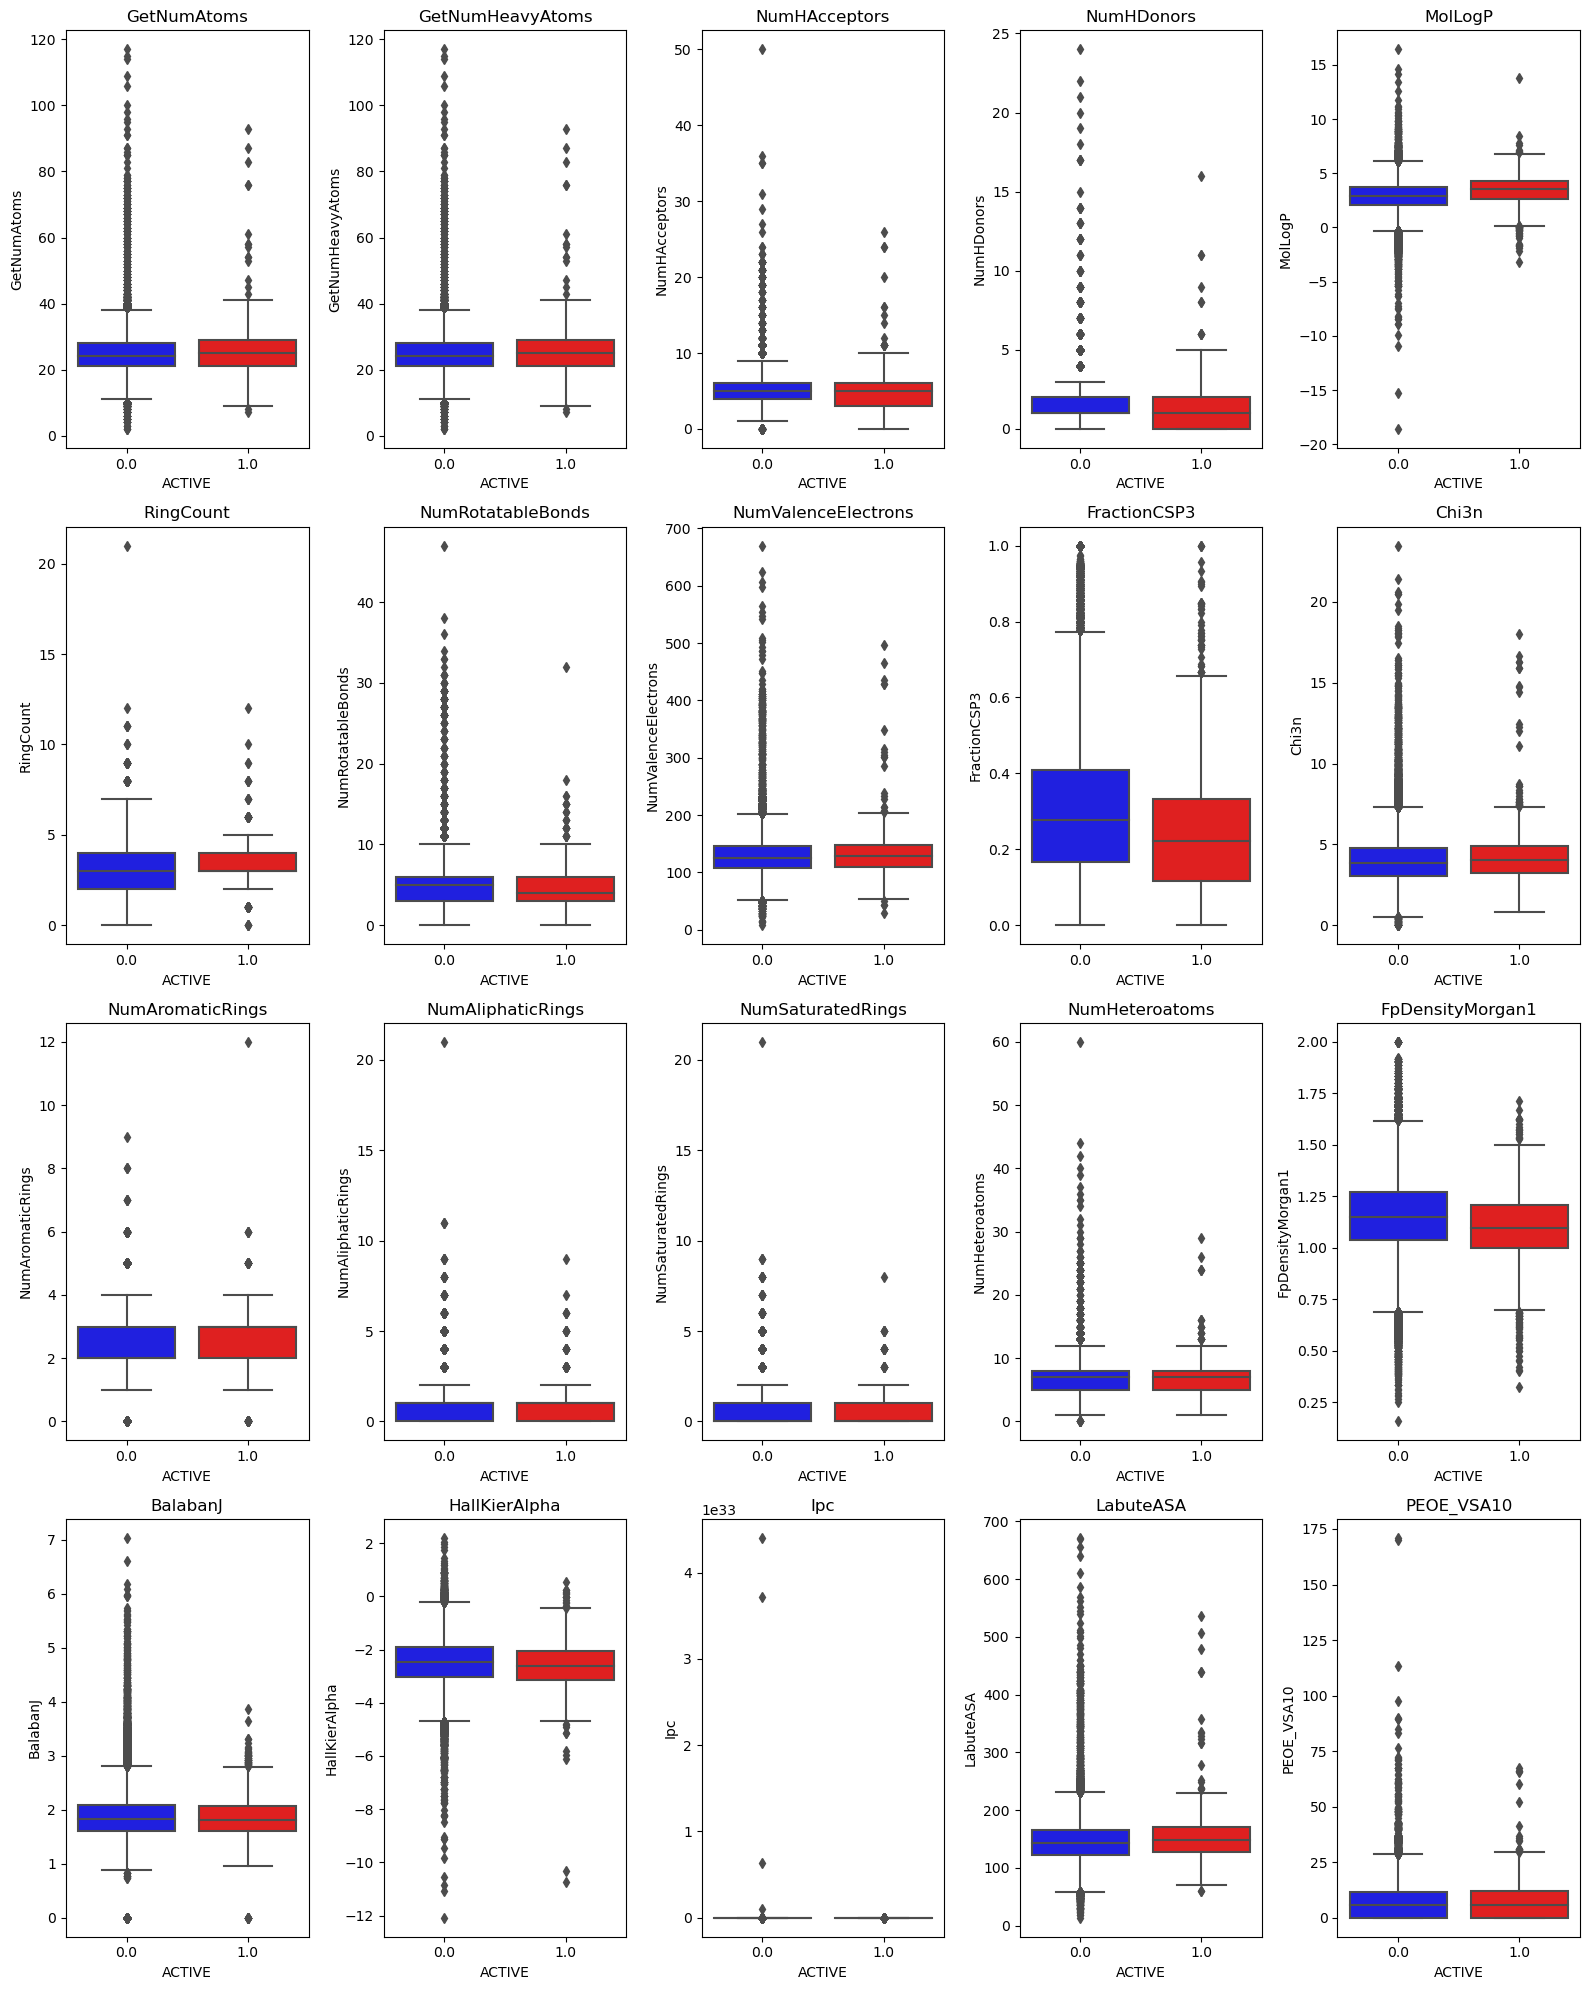

In [6]:
# Create subplots
fig, ax = plt.subplots(4, 5, figsize=(16,4*5))

# Select column to plot
cols = train_df.columns[2:-1].to_numpy().reshape((4,5))

# Create for loop
for i in range(4):
    for j in range(5):
        sns.boxplot(x='ACTIVE', y=cols[i,j], data=train_df, palette={0:'blue', 1:'red'}, ax=ax[i,j])
        ax[i,j].set_title(cols[i,j])

plt.tight_layout()
plt.show()

Thanks to this boxplot it is clear to see how the distribution mentioned in the previous describe method follows the main conclusions derived from it. The basic behavior between the box (q1-q3) seems relatively similar, its when the max values get involve when there is a significant difference between data. This also can imply that if outlier removal is to be applied in later steps, some of this difference between labels might get neglected.

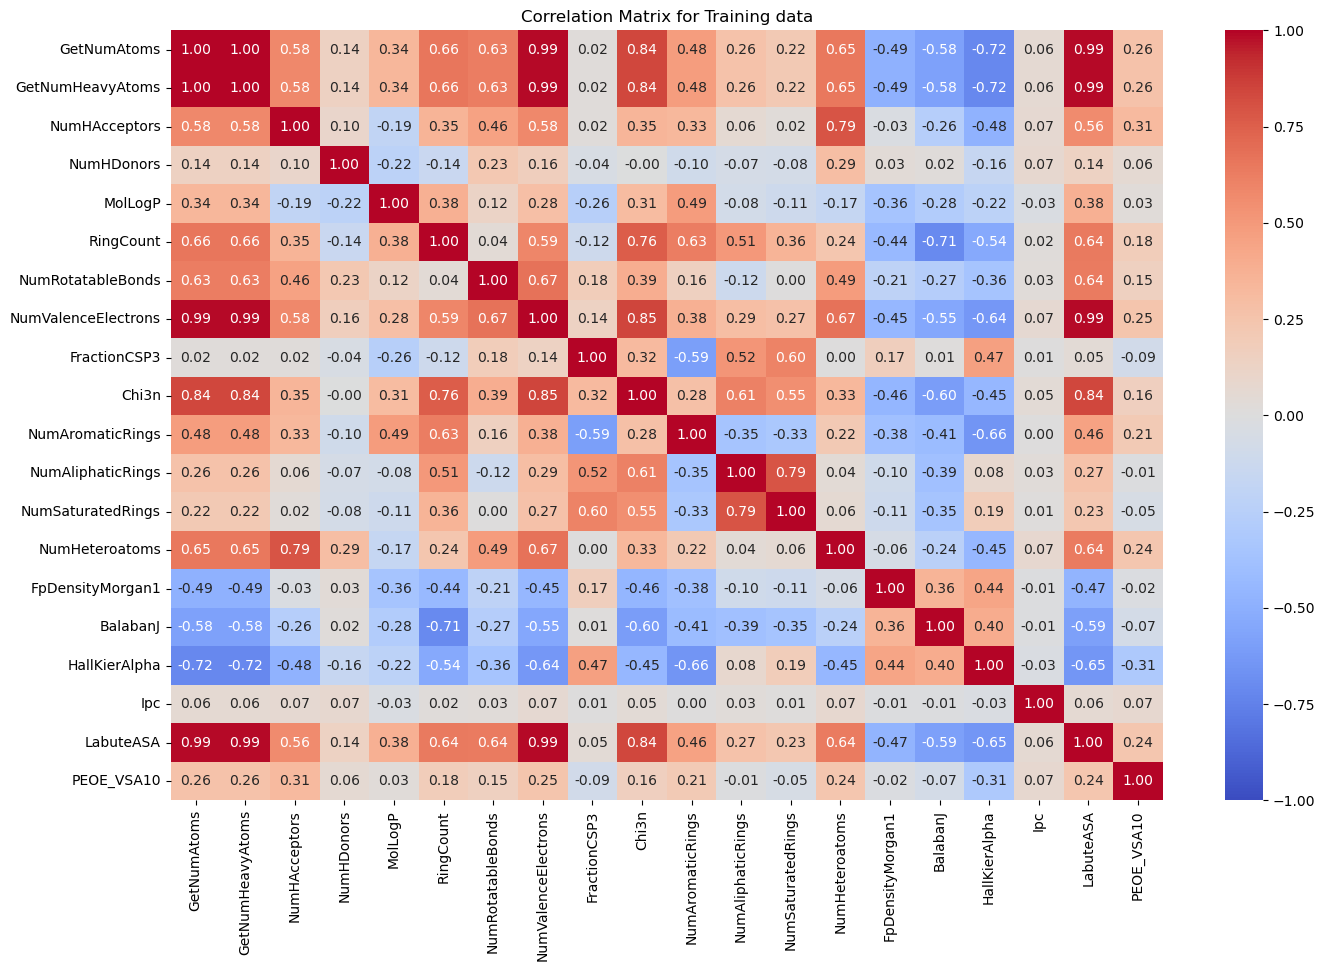

In [9]:
# Create a heatmap
plt.figure(figsize=(16,10))

sns.heatmap(train_df.iloc[:,2:-1].corr(), annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1)
plt.title('Correlation Matrix for Training data')

plt.show()

There is a wide range of linear correlation values within the variables chosen for the analysis. It is important to note that both _GetNumAtoms_ and _GetNumberHeavyAtoms_ have the same correlation values across all variables, this could mean that keeping just one variables is enough as both of them are carrying roughly the same information. _NumValanceElectrons_ is another variables that is highly correlated with the previous two, this is expected because the number of atoms can, in a certain way, determine the number of valance electrons. _LabuteASA_ is another variable that shows high correlation with the previous three variables. The last relevant positive correlation is between _Chi3n_ and _RingCount_.

For negative corelations the ones that stand out the most are _BalanJ_ with _RingCount_, and _GetNumAtoms_ with _HallKierAlpha_.

Also, there is a variable that barely has any correlation with the others, _IPC_.

## **Data Preprocessing**

In [45]:
# Import necessary libraries to perform data preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer

# Selecting columns to perform transformation
col_order = train_df.columns.tolist()
cols_to_keep = ['INDEX', 'SMILES', 'MorganFingerprint', 'ACTIVE']
cols_to_scale = train_df.columns[[5,7,10,16,20]].tolist()
cols_to_bin = [col for col in train_df.columns.tolist() if col not in cols_to_scale + cols_to_keep]

# Create a column transformer to perform transformations for variables within a dataframe
ct = ColumnTransformer([
    ('minmax_scaler', MinMaxScaler(), cols_to_scale), # Other nuemrical features
    ('binning', KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform'), cols_to_bin), # Selecting variables with more difference in boxplot
    ('pass', 'passthrough', cols_to_keep) # Keep columns INDEX and SMILES
], remainder='passthrough', verbose_feature_names_out=False).set_output(transform='pandas')

# Add a dummy column to use column transformer
test_df['ACTIVE'] = 0

# Apply the column transformations for the data
train_df_transformed = ct.fit_transform(train_df)[col_order]
test_df_transformed = ct.transform(test_df)[col_order[:-1]]

# Drop the dummy column
test_df.drop('ACTIVE', axis=1, inplace=True)

display(train_df_transformed.head())
display(test_df_transformed.head())

,INDEX,SMILES,GetNumAtoms,GetNumHeavyAtoms,NumHAcceptors,NumHDonors,MolLogP,RingCount,NumRotatableBonds,NumValenceElectrons,FractionCSP3,Chi3n,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeteroatoms,FpDensityMorgan1,BalabanJ,HallKierAlpha,Ipc,LabuteASA,PEOE_VSA10,MorganFingerprint,ACTIVE
0,1,CCCc1sc(N)nc1-c1ccc(C)cc1,1.0,1.0,0.0,0.041667,6.0,0.095238,0.0,1.0,0.307692,1.0,1.0,0.0,0.0,0.0,0.593310,3.0,7.0,0.0,0.131692,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
1,2,CCCCNC(=O)Cn1cnc2c(cnn2-c2ccc(C)c(C)c2)c1=O,2.0,2.0,1.0,0.041667,5.0,0.142857,1.0,1.0,0.368421,1.0,2.0,0.0,0.0,1.0,0.582882,2.0,6.0,0.0,0.209342,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
2,3,O=C(NCCC1=CCCCC1)C1CCN(S(=O)(=O)N2CCOCC2)CC1,2.0,2.0,0.0,0.041667,5.0,0.142857,1.0,2.0,0.833333,2.0,0.0,1.0,0.0,1.0,0.520314,2.0,7.0,0.0,0.217336,0.0,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
3,4,N#Cc1c(-c2c(Cl)cccc2Cl)noc1/C=C/Nc1ccc(C(=O)O)cc1,2.0,2.0,1.0,0.083333,6.0,0.142857,1.0,1.0,0.000000,1.0,2.0,0.0,0.0,1.0,0.558164,2.0,6.0,0.0,0.228449,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0
4,5,Cc1cc(C)cc(OCC(=O)Nc2ccc(F)cc2)c1,1.0,1.0,0.0,0.041667,6.0,0.095238,0.0,1.0,0.187500,1.0,1.0,0.0,0.0,0.0,0.511972,2.0,6.0,0.0,0.157221,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.0


,INDEX,SMILES,GetNumAtoms,GetNumHeavyAtoms,NumHAcceptors,NumHDonors,MolLogP,RingCount,NumRotatableBonds,NumValenceElectrons,FractionCSP3,Chi3n,NumAromaticRings,NumAliphaticRings,NumSaturatedRings,NumHeteroatoms,FpDensityMorgan1,BalabanJ,HallKierAlpha,Ipc,LabuteASA,PEOE_VSA10,MorganFingerprint
0,153231,O=C(N/N=C\c1cccc(Br)c1)c1ccccc1-n1cccc1,1.0,1.0,0.0,0.041667,6.0,0.142857,0.0,1.0,0.000000,1.0,2.0,0.0,0.0,0.0,0.481323,2.0,6.0,0.0,0.195537,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,153232,CCOc1ccc(/C=N/NC(=O)c2nnn(-c3nonc3N)c2COc2ccc(...,2.0,2.0,2.0,0.083333,5.0,0.190476,1.0,2.0,0.142857,1.0,3.0,0.0,0.0,2.0,0.537490,2.0,5.0,0.0,0.270843,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,153233,Cc1cc2nc(Cl)c(Cl)nc2cc1C,1.0,1.0,0.0,0.000000,6.0,0.095238,0.0,0.0,0.200000,0.0,1.0,0.0,0.0,0.0,0.380282,4.0,7.0,0.0,0.119134,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,153234,O=C1NC(=S)N/C1=C/c1cc([N+](=O)[O-])ccc1N1CCOCC1,1.0,1.0,1.0,0.083333,5.0,0.142857,0.0,1.0,0.285714,1.0,0.0,0.0,0.0,1.0,0.622780,2.0,6.0,0.0,0.187413,0.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,153235,Cc1c(C(=O)OCC(=O)C(C#N)=C2Nc3ccccc3N2)oc2ccccc12,2.0,2.0,1.0,0.083333,6.0,0.190476,0.0,1.0,0.095238,1.0,2.0,0.0,0.0,1.0,0.496479,2.0,5.0,0.0,0.222317,1.0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## **Model Selection**

In [59]:
# Import the necessary libraries for modeling, hyperparameter tunning, cross-valudation, and auc scoring
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline

# Import necessary libraries to address imbalance between classes
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from imblearn.over_sampling import RandomOverSampler

In [78]:
# Separating features from target variable
X = train_df_transformed.iloc[:,2:-2] # Features except INDEX, SMILES and ACTIVE
y = train_df_transformed.iloc[:,-1] # Target variable ACTIVE

# Use train test split to create training and testing datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# Print the shapes of each of the datasets
print(f"Size of training dataset: {X_train.shape}")
print(f"Size of testing dataset: {X_test.shape}")

# Print the value counts for ACTIVE target feature to show imbalance
print(f"\nValue counts for training target feature: {y_train.value_counts()}")
print(f"\nValue counts for testing target feature: {y_test.value_counts()}")

Size of training dataset: (122584, 20)
Size of testing dataset: (30646, 20)

Value counts for training target feature: ACTIVE
0.0    121157
1.0      1427
Name: count, dtype: int64

Value counts for testing target feature: ACTIVE
0.0    30289
1.0      357
Name: count, dtype: int64


In [81]:
# Set up learning algorithms and grid parameters for CV
rfc = RandomForestClassifier()
gbc = GradientBoostingClassifier()
mlp = MLPClassifier()

# Grid parameters
param_distributions_rfc = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 10, 20],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt'],
    'bootstrap': [True],
}

param_distributions_gbc = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['auto', 'sqrt'],
    'subsample': [0.8, 0.9],
    'max_leaf_nodes': [None, 10, 20],
}

param_distributions_mlp = {
    'hidden_layer_sizes': [(50,), (100,)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.001],
    'learning_rate': ['constant', 'invscaling'],
    'max_iter': [200, 300],
    'batch_size': ['auto', 32],
    'momentum': [0.9, 0.95],
    'early_stopping': [True],
    'validation_fraction': [0.1]
}

# Assemble to RandomizedSearchCV for each of the models
rfc_rcv = RandomizedSearchCV(rfc, param_distributions_rfc, n_iter=100, scoring='roc_auc', cv=5, random_state=42, error_score='raise')
gbc_rcv = RandomizedSearchCV(gbc, param_distributions_gbc, n_iter=100, scoring='roc_auc', cv=5, random_state=42)
mlp_rcv = RandomizedSearchCV(mlp, param_distributions_mlp, n_iter=100, scoring='roc_auc', cv=5, random_state=42)

## **Results**

## **Conclusions**